# Energy Efficient Operation of Network Elements with Stepwise Power Profile

Due to the rising demand to reduce the energy consumption, modern network elements (will) have the ability to energise and de-energise subsystems on command as the network element’s traffic data rate varies. This results in stepwise power profiles. A “Minimal Power Principle” is described and applied to construct simple look-up table indicating the number and type of sub-systems to energise to minimise the overall power consumption of a network element with modular power management. 



---
>(c) Tobias Hossfeld  (Feb 2026)<br><br>
> This script implements the minimap power principle; the figures are part of the following paper, that is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Kerry Hinton (, University of Melbourne, Australia) & Tobias Hoßfeld (University of Würzburg, Germany): "Energy Efficient Operation of Network Elements with Stepwise Power Profile" (Feb 2026)*
---

## Minimial Power Principle and Algorithms for the Real-World Example 
**Minimal Power Principle (MPP):**
In general, the total power consumption of the energised plugins for a given signal bit rate is minimised by allocating as much of the data signal bit rate as possible to plugin types with the lowest energy per bit and that collectively closely match the bit rate.

As a real-world example a modern router with modular power management of line cards and optical SFP plugin connectors is considered. The router uses modular power management on optical plugins than accommodate bit rates of 10G, 40G, 100G, 400G and 800G. The parameters for the supported bitrates $B_j$ as well as the power consumption $\beta_j$ for $j=1,\dots,N$ are provided in the following. For the numerical result, we consider $N=5$.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache
from collections import namedtuple

B = np.array([10,40,100,400,800]) # Gbps for the different module types
beta = np.array([1, 3.5, 5.5, 12, 16]) # Watt for the different module types

### Single-type only 
This algorithm selects the most energy efficient number plugins of a single type to energise to deal with traffic bit rate. 

`getSingleTypeOnlySolution(x)` computes a solution where only one module type is used to satisfy the demand `x`.  For each module type, it calculates the required number of modules, estimates the
corresponding power consumption, and selects the module type with the minimum power usage.  

Returns a vector in which only the optimal module type has a nonzero entry, along
with the associated minimum power consumption.


In [6]:
def getSingleTypeOnlySolution(x):    
    required_modules = np.ceil(x/B).astype('int')
    
    power_consumption = beta*required_modules
    i = np.argmin(power_consumption)
    
    mjs = np.zeros(len(B))
    mjs[i] = required_modules[i]
    
    return mjs, power_consumption[i]

### Multiple-types 
We now consider energising multiple different plugin types and apply the MPP. The solution for determining the number $m_j$ of different plugin types $j$ that minimizes the overall power consumption can be formulated as an integer optimization problem. 

\begin{align}
& \min \sum_{j=1}^N m_j \beta_j \\
& \text{such that }  \sum_{j=1}^N m_j B_j \geq x && \text{ with } \quad m_j \in \mathbb{N}_0, \forall j\in\{1,\dots,N\}
\end{align}

This optimisation task corresponds to an unbounded integer knapsack problem in minimisation form. Each plugin type represents an item with value equal to its throughput and weight equal to its power consumption contribution. The goal is to choose any non-negative number, $m_j$, of items to minimize the total weight while ensuring that the accumulated throughput meets or exceeds the required throughput data rate $x$.

#### Implementation description
This implements a dynamic programming approach to find the minimum total power needed to reach at least `x` Gbps, where each module type `j` contributes bandwidth `B[j]` and costs power `beta[j]`.

##### `best_cost(rem)`
- A recursive function with memoization via `@lru_cache`.
- Returns the minimal power consumption required to achieve at least `rem` remaining Gbps.
- Base case: if `rem <= 0`, no more bandwidth is needed $\rightarrow" cost `0.0`.
- Transition: try adding one module of each type `j`, giving:
  - immediate cost `beta[j]` plus optimal future cost `best_cost(rem - B[j])`
- Takes the minimum over all choices and caches the result to avoid recomputation.

##### `get_optimal_config_dyn(x)`
- Uses `best_cost` to **reconstruct an optimal module count vector**.
- Starts with `rem = x` and repeatedly:
  - computes the cost of choosing each module type next:
    `beta[j] + best_cost(rem - B[j])`
  - selects the module type(s) achieving the minimum cost
  - **tie-break rule:** if multiple are optimal, chooses the one with the **largest** `B[j]`
- Updates `counts` and decreases `rem` by the chosen bandwidth until `rem <= 0`.
- Returns:
  - `counts`: the optimal number of modules of each type
  - `counts @ beta`: total power consumption of that configuration


In [8]:
#%% MULTI type solution
@lru_cache(maxsize=None)
def best_cost(rem):    
    """Minimal power to get at least `rem` Gbps."""
    if rem <= 0:        
        return 0.0
    # vector of possible next costs: beta[j] + best_cost(rem - B[j])
    costs = beta + np.array([best_cost(rem - bj) for bj in B])    
    return float(costs.min())

def getMultipleTypeSolution(x):
    """Reconstruct optimal config, preferring larger B first in ties."""
    counts = np.zeros(len(B), dtype=int)
    rem = x

    while rem > 0:
        # cost for picking each port type j
        costs = beta + np.array([best_cost(rem - bj) for bj in B])
        min_cost = costs.min()

        # find all equally optimal candidates
        candidates = np.where(costs == min_cost)[0]

        # among them, pick the one with the biggest B
        best_j = candidates[np.argmax(B[candidates])]

        counts[best_j] += 1
        rem -= B[best_j]

    return counts, counts @ beta

### Parameter Study
This code evaluates bandwidth demands from 1 to 500 Gbps and computes the required module configurations and power consumption using two different strategies. For each demand value, it first determines a restricted solution where only a single module type may be used, storing the resulting module counts and total power consumption. 

It then computes an optimal solution that allows combining multiple module types, using a dynamic programming approach. The resulting data enables a direct comparison of power efficiency between single-type-only and multi-type configurations across the full range of supported bandwidths.


In [15]:
from tqdm.notebook import tqdm
import numpy as np

xs = np.arange(1, 501)  # supported bandwidths in Gbps

# single type only
mjs_single = np.zeros((len(xs), len(B)), dtype=int)
PCs_single = np.zeros(len(xs))

for i, x in tqdm(enumerate(xs), total=len(xs), desc="Single-type"):
    mjs_single[i, :], PCs_single[i] = getSingleTypeOnlySolution(x)

# multiple types (dynamic programming)
mjs_dyn = np.zeros((len(xs), len(B)), dtype=int)
PCs_dyn = np.zeros(len(xs))

for i, x in tqdm(enumerate(xs), total=len(xs), desc="Multi-type"):
    mjs_dyn[i, :], PCs_dyn[i] = getMultipleTypeSolution(x)

Single-type:   0%|          | 0/500 [00:00<?, ?it/s]

Multi-type:   0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
def plotResults(M, title, fignum=1, figsize=(10,6), sharex=True):
    fig, axs = plt.subplots(3, 1, num=fignum, figsize=figsize, clear=True)
    # number of elements
    plt.sca(axs[0])
    bottom = np.zeros( M.shape[0])    
    for j in range(M.shape[1]):
        plt.bar(xs, M[:, j], width=1, bottom=bottom, label=f"Type {j+1}: {B[j]}G")
        bottom += M[:, j]        
    nmax = M.max()
    plt.xticks(np.arange(0,501,50))
    plt.yticks(np.arange(0,nmax+1))
    plt.ylim([0, nmax+0.5])
    plt.ylabel("number")
    plt.legend(loc='best')
    plt.xlabel('throughput (Gbps)')
    plt.grid(which='major',axis='y')
    plt.title(title) 
    # supported throughput
    plt.sca(axs[1])    
    bottom = np.zeros( M.shape[0])    
    width = 1.0     
    for j in range(M.shape[1]):
        heights = M[:, j] * B[j]
        # draw the main stacked bar segment
        plt.bar(xs,heights,width=width,bottom=bottom,
            label=f"Type {j+1}: {B[j]} Gbps",zorder = 1)
    
        # draw internal "unit" edges at each multiple of beta[j]
        for x_i, m_ij, b0 in zip(xs, M[:, j], bottom):
            # for m_ij units, we need m_ij-1 internal lines
            for k in range(1, int(m_ij)+1):
                y = b0 + k * B[j]
                # x_i is the center of the bar, so go half-width left/right
                plt.hlines(y,x_i - width / 2.0,x_i + width / 2.0,
                    colors="black",linewidth=1,zorder = 999)    
        # update bottom for the next type in the stack
        bottom += heights    
    plt.plot(xs,xs,'k:',zorder=99, lw=0.8)
    plt.xticks(np.arange(0,501,50))
    plt.ylabel("supported throughput (Gbps)")
    plt.legend(loc='best')
    plt.xlabel('throughput (Gbps)')
    plt.grid(which='major',axis='y', zorder=5)
    
    # supported throughput
    plt.sca(axs[2])
    bottom = np.zeros( M.shape[0])    
    for j in range( M.shape[1]):
        heights = M[:, j] * beta[j]
        # draw the main stacked bar segment
        plt.bar(xs,heights,width=width,bottom=bottom,
            label=f"Type {j+1}: {B[j]} Gbps",zorder=1)    
        # draw internal "unit" edges at each multiple of beta[j]
        for x_i, m_ij, b0 in zip(xs, M[:, j], bottom):
            # for m_ij units, we need m_ij-1 internal lines
            for k in range(1, int(m_ij)+1):
                y = b0 + k * beta[j]                
                plt.hlines(y,x_i - width / 2.0,x_i + width / 2.0,
                    colors="black",linewidth=1,zorder=9999)    
        bottom += heights    
    plt.xticks(np.arange(0,501,50))
    plt.ylabel("power consumption (Watt)")
    plt.legend(loc='best')
    plt.xlabel('throughput (Gbps)')
    plt.grid(which='major',axis='y', zorder=10)    
    plt.tight_layout()
    plt.show()

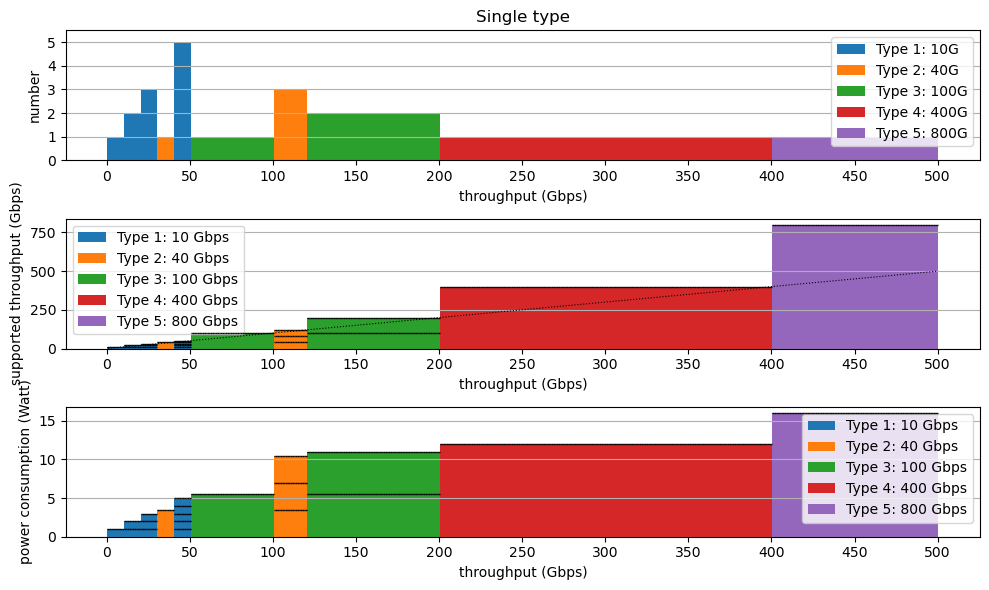

In [21]:
plotResults(mjs_single, "Single type")

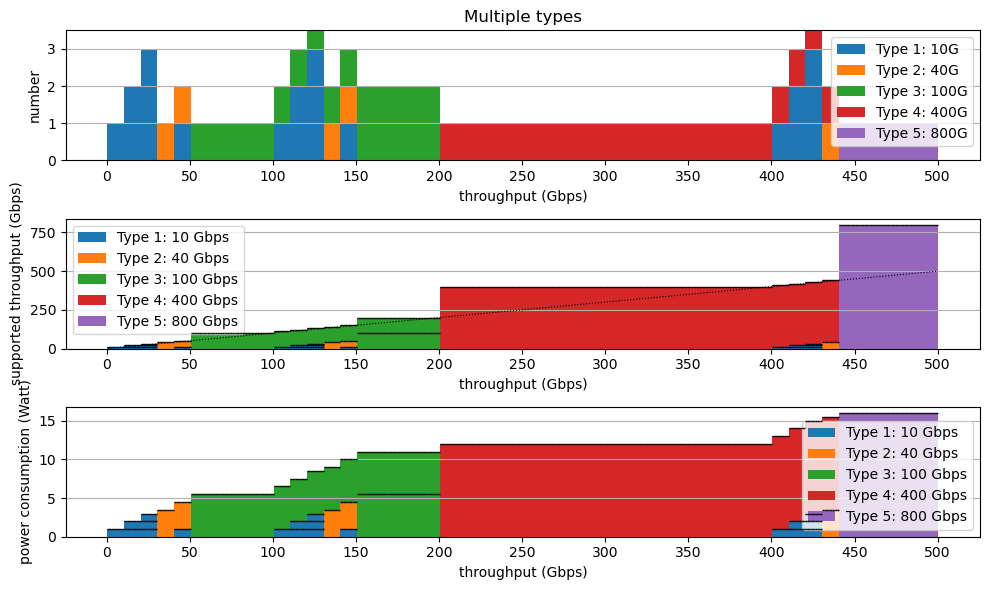

In [22]:
plotResults(mjs_dyn, "Multiple types", fignum=2)

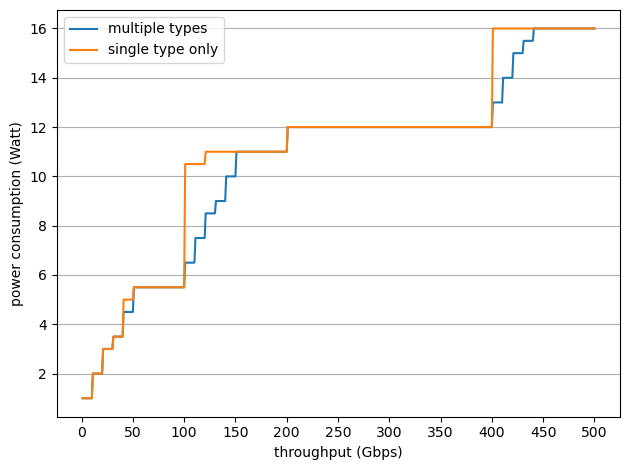

In [23]:
plt.plot(xs, PCs_dyn, label='multiple types')
plt.plot(xs, PCs_single, label='single type only')
plt.xticks(np.arange(0,501,50))
plt.ylabel("power consumption (Watt)")
plt.legend(loc='best')
plt.xlabel('throughput (Gbps)')
plt.grid(which='major',axis='y')
plt.tight_layout()
plt.show();